# Fit VNA resonances at different power outputs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from iminuit.cost import LeastSquares
import sys

sys.path.append('../src')
sys.path.append('../src/analysis/fitting')
sys.path.append('../src/graphics')

import analysis.fitting.models as md
from analysis.fitting.FitAPI import Fitter, Model
from analysis.fitting.searcher import ResonancePeakSearcher
from graphics.plots import plot_fit
from graphics.colours import Palette
from typography import Typography, Font

In [2]:
# graphics settings
palette = Palette("Quantum Science", {
    'primary': "#046A3A",      # Deep ocean blue - sophisticated and trustworthy
    'secondary': '#1B263B',    # Midnight navy - elegant depth
    'accent': "#E65039",       # Vibrant coral - high-impact highlights
    'accent2': '#FFD23F',      # Golden yellow - energy and precision
    'background': '#F8F9FB',   # Ultra-clean off-white - pristine lab feel
    'background2': '#E8EDF3',  # Subtle blue-gray - sophisticated secondary
    'text_primary': '#1A1B23', # Rich charcoal - maximum readability
    'text_secondary': '#4A5568', # Cool gray - perfect for secondary text
    'status_error': '#E53E3E',  # Crisp red - clear error indication
    'neutral_light': "#F3F3F3",  # Cool light gray - subtle grid
    'neutral_dark': "#2D3748",   # Professional dark gray - strong borders
})

typography = Typography(
    title=Font('Palatino Linotype', 20, family='serif'),   
    subtitle=Font('Verdana', 16, family='sans-serif'),
    body=Font('Verdana', 13, family='sans-serif'),    
    caption=Font('Verdana', 11, family='sans-serif')  
)

In [3]:
def read_peaks_data(filename):
    data_dict = {}       # stores the dataset values as NumPy arrays
    metadata_dict = {}   # stores the metadata (attributes) for each dataset
    with h5py.File(filename, 'r') as hf:
        for pk in range(1,5):
            group_name = f"peak_{pk}"
            for pw in range(-45, 0, 5):
                dataset_name = f"peak_{pk}_{pw}_dBm"
                dataset_path = f"{group_name}/{dataset_name}"
                if dataset_path in hf:
                    dataset = hf[dataset_path][()]
                    data_dict[(pk, pw)] = dataset
                    metadata_dict[(pk, pw)] = {}
                    for attr in hf[dataset_path].attrs:
                        metadata_dict[(pk, pw)][attr] = hf[dataset_path].attrs[attr]
                else:
                    print(f"Dataset {dataset_path} not found in the HDF5 file")

    return data_dict, metadata_dict

In [4]:
data_all, meta_all = read_peaks_data('../Experiments/ResonatorsExperiment/run-5/data/peaks_data.h5')

# Extract data and metadata for all peaks at -45 dBm
data = {k: v for k, v in data_all.items() if k[1] == -45}
meta = {k: v for k, v in meta_all.items() if k[1] == -45}

C:\Users\ferio\AppData\Local\Temp\ipykernel_27532\887365696.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


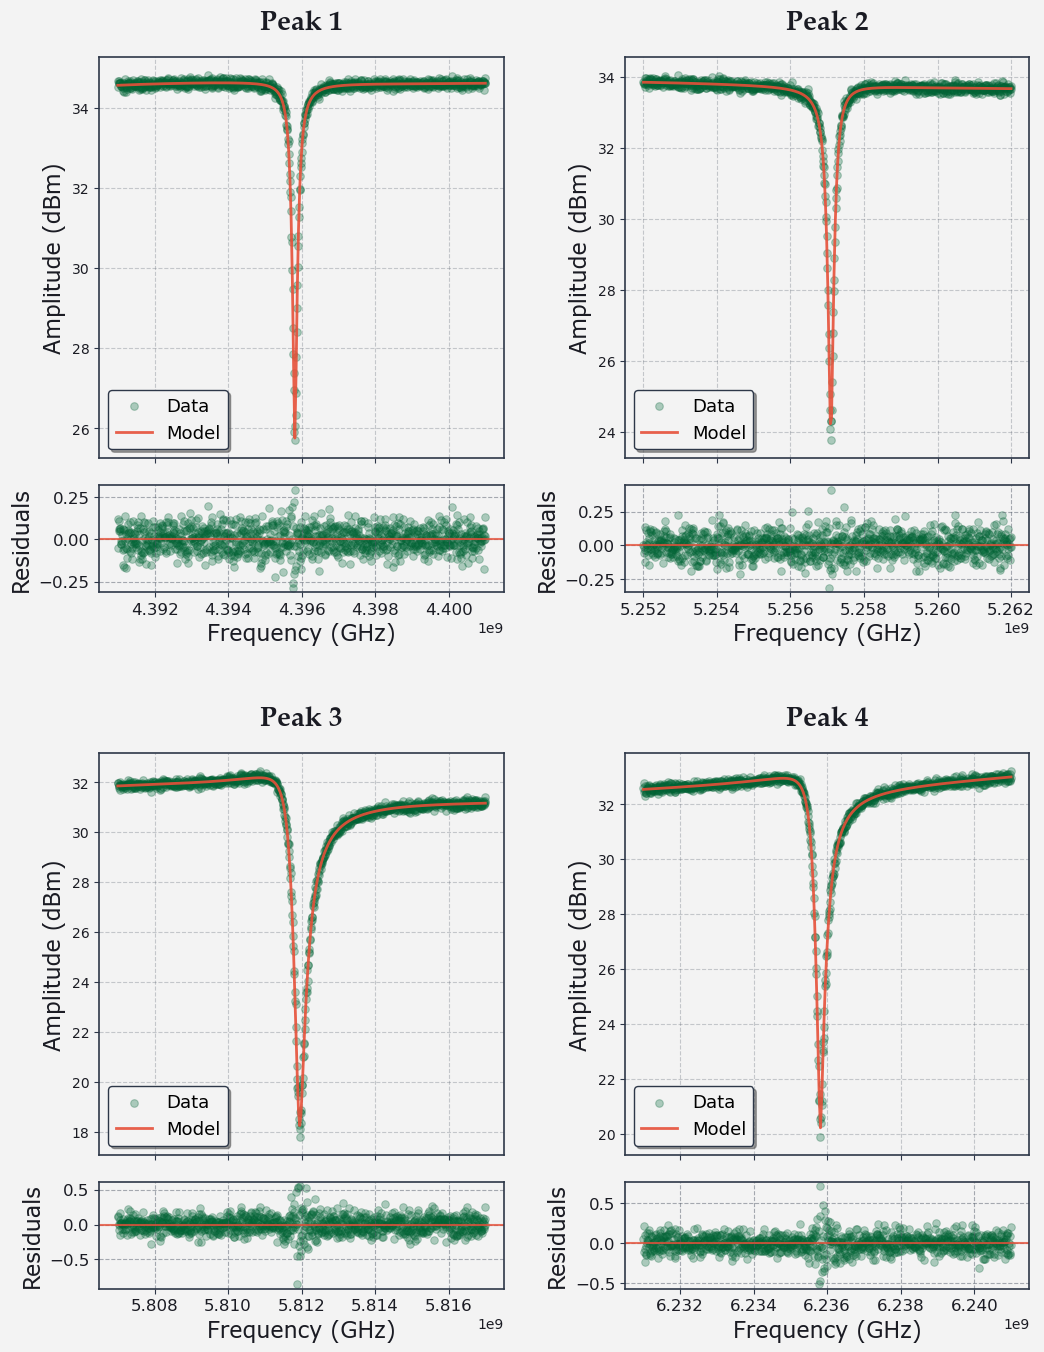

In [16]:

resonance_frequneces = []

nof_peaks = 4
nrows = 2
ncols = 2
#fig, ax = plt.subplots(int(np.sqrt(nof_peaks)), int(np.sqrt(nof_peaks)), figsize=(8, 8))
fig, ax = plt.subplots(nrows, ncols, figsize=(12, nrows * 8), gridspec_kw={'hspace':0.3, 'wspace':0.3})
row_iter = 0
col_iter = 0

for k, peak_data in data.items():
    f = peak_data[0]
    I = peak_data[1]
    Q = peak_data[2]

    amp = np.sqrt(I**2 + Q**2)
    amp_dBm = 20 * np.log10(amp * 1e3)  # Convert to dBm
    peak_data = np.array([f, amp_dBm]).T

    # try to fit
    model = md.resonance_model
    fitter = Fitter(model_function=md.resonance_model, 
                        param_names=["f0", "phi", "Qt", "Qc", "A", "B", "C", "D", "K", "fmin"], 
                        data=peak_data, 
                        loss_function=LeastSquares
                    )

    searcher = ResonancePeakSearcher(version="T")
    result = fitter.fit(searcher=searcher)

    # Check if the fit was successful
    if result.valid:
        # p-value test
        p_value = fitter.p_value()
        if p_value < 0.05:
            print(f"Fit for peak {k[0]}, power {k[1]} dBm failed (p-value: {p_value})")
            # For now we take the fmin as the resonance frequency
            resonance_frequency = searcher.params['fmin']
            resonance_frequneces.append(resonance_frequency)
            continue
        else:
            # Extract the resonance frequency from the fitted parameters
            resonance_frequency = result.values['f0'] + searcher.params['fmin']
            resonance_frequneces.append(resonance_frequency)
            # Plot the fit result
            fitted_params = result.values.to_dict()
            fitted_params['fmin'] = searcher.params['fmin']
            plot_fit(peak_data, model, fitted_params,
                     title=f'Peak {k[0]}', #with power -45dBm
                     xlabel='Frequency (GHz)', 
                     ylabel='Amplitude (dBm)', 
                     palette=palette, 
                     typography=typography, 
                     ax=ax[row_iter, col_iter],
                     rasterize_points=True)
    else:
        print(f"Fit for peak {k[0]}, power {k[1]} dBm failed (invalid result)")
        # For now we take the fmin as the resonance frequency
        resonance_frequency = searcher.params['fmin']
        resonance_frequneces.append(resonance_frequency)
        # Plot anyway the data
        ax[row_iter, col_iter].scatter(peak_data[:, 0], peak_data[:, 1], label='Data', color='blue', alpha=0.5, s=4)
        # add labels, title and legend
        ax[row_iter, col_iter].set_xlabel('Frequency (GHz)')
        ax[row_iter, col_iter].set_ylabel('Amplitude (dBm)')
        ax[row_iter, col_iter].set_title(f'Peak {k[0]} with Power {k[1]} dBm')
        ax[row_iter, col_iter].legend()
        ax[row_iter, col_iter].grid()

    # update iterators
    col_iter += 1
    if col_iter >= int(np.sqrt(nof_peaks)):
        col_iter = 0
        row_iter += 1

# adjust the layout
plt.tight_layout()
plt.show()

In [17]:
resonance_frequneces

[4395814246.033261, 5257103741.141552, 5811881062.0089245, 6235768836.275364]